# Try this exercises

## 1. Testing the Central Limit theorem

Model fitting (which we will talk about later) requires comparison of a model with data using some figure of merit.  The figure of merit that we often use is $\chi^2$ (which we will also talk about later.).   *An issue is that the use of $\chi^2$ implicitly assumes that the uncertainties on the data have a normal distribution.* 

X-ray astronomy is (generally) a photon-poor discipline, and researchers are often working in the Poisson regime.  To do spectral fitting, researchers often bin the spectra in energy so that there are at least 15-25 counts per bin.  

Your task in this problem is to design and carry out a numerical experiment to test how good the assertion is that binning spectra by 15-25 counts per bin gives uncertainties with a normal distribution.  For good measure, compute the differences for the range [5,30] counts per bin.  In this case, you may assume that the normal distribution that you will compare with has $\sigma$ equal to the square root of the number of counts.  For uniformity, report your results in a graph showing the percentage difference, i.e., (observed-normal)/normal.

And to be specific, address the reliability at $1 \sigma$ (i.e., confidence intervals  $[0.1587,0.8413]$) and $2 \sigma$ (confidence intervals of $[0.0227501,0.977250]$).


Finally, discuss your results.  

## Answer



In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

rng = np.random.default_rng()

To be honest, this question confused me, and I was uncertain of what exactly I was trying to do. The title of the problem is "testing the central limit theorem", however after looking at the discussion board hints on Canvas, I was way off and it seemed like just testing the difference between two types of distributions.

My first test was to compare the fraction of points within the same $n-\sigma$ confidence intervals for $n = 1, 2$, and this is given below. I present a plot of the percent difference between the fraction of points sampled from the Poisson distribution within $ \sigma = \sqrt{N}$ (where $N$ is the counts per bin) compared to the expected fractional amount given in the question. I do this for every value of $N$ in $[5, 30]$. As we see, the $1\sigma$ confidence range is extremely variable and not descriptive of a normal distribution for most values of N (however there are a few "sweet spots"). The $2\sigma$ confidence region, however, is quite similar between the two distributions for each value of $N$.

In my second test I compared the density of a sample taken from a Poisson distribution (given using a histogram/binning) to a normal distribution. I took the percent difference at each point and took the mean of those differences, all for each value of $N$, and this is plotted below as well. In general, the histogram method is difficult to get reasonable results, which leads to large percent differences. Regardless, this test displays that the larger values of $N$ generally fit a normal distribution better.

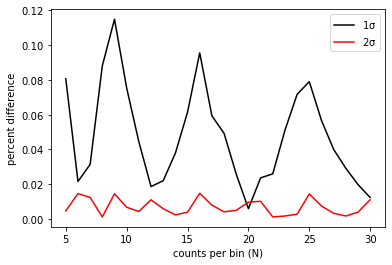

In [2]:
N = np.arange(5, 31)

def get_percent_diff(N, n_samples=10000):
    # get "observed" data from a Poisson
    sample = rng.poisson(N, size=n_samples)
    
    # number within different confidence intervals
    mask = (sample < N + np.sqrt(N)) & (sample > N - np.sqrt(N))
    N_1sig_pois = len(sample[mask])
    
    mask = (sample < N + 2 * np.sqrt(N)) & (sample > N - 2 * np.sqrt(N))
    N_2sig_pois = len(sample[mask])

    # expected number in a confidence interval for a normal distribution
    N_1sig_norm = (0.8413 - 0.1587) * n_samples
    N_2sig_norm = (0.97725 - 0.0227501) * n_samples

    p_diff_1sig = np.abs((N_1sig_pois - N_1sig_norm) / N_1sig_norm)
    p_diff_2sig = np.abs((N_2sig_pois - N_2sig_norm) / N_2sig_norm)
    
    return p_diff_1sig, p_diff_2sig

p_diff = np.array([get_percent_diff(i) for i in N])

fig, ax = plt.subplots()

ax.plot(N, p_diff[:, 0], 'k-', label=r'$\mathrm{1\sigma}$')
ax.plot(N, p_diff[:, 1], 'r-', label=r'$\mathrm{2\sigma}$')

ax.set_xlabel('counts per bin (N)')
ax.set_ylabel('percent difference')

ax.legend()

plt.show()

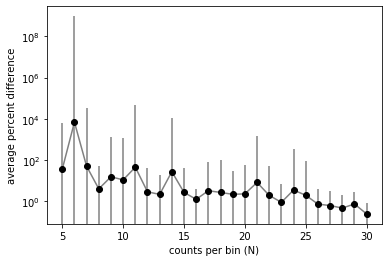

In [3]:
N = np.arange(5, 31)

def get_percent_diff(N, n_samples=100000):
    # get "observed" data from a Poisson
    samples = rng.poisson(N, size=n_samples)

    # use a histogram to get the density of samples (expected Poisson density)
    y_obs, x = np.histogram(samples, density=True, bins=50)
    x_obs = (x[:-1] + x[1:]) / 2
    
    # get rid of empty bins
    mask = y_obs != 0.
    x_obs = x_obs[mask]
    y_obs = y_obs[mask]
    
    # create the normal dist. model to compare with
    mod_params = N, np.sqrt(N)
    y_mod = ss.norm.pdf(x_obs, *mod_params)
    
    p_diff = (y_obs - y_mod) / y_mod
    return p_diff.mean(), p_diff.var()

p_diff = np.array([get_percent_diff(i) for i in N])

fig, ax = plt.subplots()

ax.plot(N, p_diff[:, 0], 'ko')
ax.errorbar(N, p_diff[:, 0], yerr=p_diff[:, 1], c='grey', zorder=-1)

ax.set_xlabel('counts per bin (N)')
ax.set_ylabel('average percent difference')
ax.set_yscale('log')

plt.show()

## 2. Constructing random draws for asymmetrical errors.

A measurement is made, and the value is found to be $5.5_{-3}^{+7}$.  The measurement is not in the Poisson regime (i.e., not a count rate), so the errors can be assumed to have a normal distribution separately.  The measurement is of something that cannot be less than zero.

Produce 10,000 draws of the appropriate distribution.  Plot a histogram of the probability density to demonstrate the result.



## Answer:



In [4]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

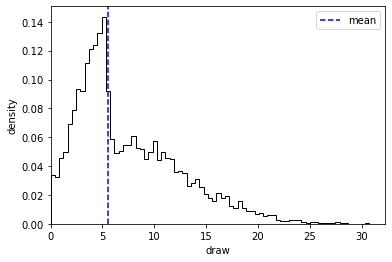

In [5]:
def asym_draw(mu, sig_lo, sig_hi, n_samples, truncation=0., _array=None):
    '''Obnoxiously vectorized drawing of asymmetric error (two normal distributions)'''
    if _array is None:
        put_indices = np.arange(n_samples)
        sample = np.empty(n_samples)
    else:
        put_indices = np.argwhere(_array < truncation)
        sample = _array
        n_samples = len(put_indices)

    # 50/50 pick from upper/lower distributions
    partition = rng.uniform(size=n_samples)
    lower = partition <= 0.5
    upper = ~lower
    n_lower = len(partition[lower])
    n_upper = n_samples - n_lower
    
    np.put(sample, put_indices[lower], rng.normal(mu, sig_lo, size=n_lower))
    np.put(sample, put_indices[upper], rng.normal(mu, sig_hi, size=n_upper))

    # correct for choosing the wrong side of the mean
    lower_corr = sample[put_indices[lower]] > mu
    upper_corr = sample[put_indices[upper]] < mu
    np.put(sample, put_indices[lower][lower_corr],
           2. * mu - sample[put_indices[lower]][lower_corr])
    np.put(sample, put_indices[upper][upper_corr],
           2. * mu - sample[put_indices[upper]][upper_corr])

    # redraw negative values
    if np.any(sample[sample < truncation]):
        asym_draw(mu, sig_lo, sig_hi, n_samples, truncation=truncation, _array=sample)

    return sample

mu = 5.5
sig1 = 3.
sig2 = 7.

n = 10000

sample = asym_draw(mu, sig1, sig2, n)

fig, ax = plt.subplots()

ax.hist(sample, bins=75, histtype='step', color='k', density=True)
ax.axvline(mu, c='b', ls='--', label='mean')

ax.set_xlabel('draw')
ax.set_ylabel('density')
ax.set_xlim(left=0)

ax.legend()

plt.show()

The solution above takes random samples (with even probability) between two different normal distributions. Because these distributions are separately normalized, there is a discontinuity at the mean (the boundary between the two distributions).